# EDA: Grand Junction Weather Data
### Christian Tuttle
##### Goal: Using weather data from the pastl 50 years in Grand Junction, Colorado, Use visualization to explore the data,  create a Principle Component Analysis of the columns of data you have, and decide what might be important, and conduct other experiments with the data


## Import necessary libraries
##### We will be using meteostat, matplotlib seaborn, and scikit-learn. 

In [90]:
%pip install meteostat
%pip install matplotlib seaborn
%pip install scikit-learn







[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.4.4/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.4.4/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.4.4/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Import the data
Import the data from meteostat, from the past 50 years in Grand Junction. Then, quickly look at the front and back of the data. 

In [96]:
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from meteostat import Point, Daily
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# Location: Grand Junction, CO
gj = Point(39.0639, -108.5506, 1475)  # lat, lon, elevation (m)

# Time range: 1975-01-01 to today
start = datetime(1975, 1, 1)
end   = datetime(2025, 9, 28)

# Fetch daily data
data = Daily(gj, start, end)
data = data.fetch()

print(data.head())
print(data.tail())
print(data.shape)

            tavg  tmin  tmax  prcp  snow  wdir  wspd  wpgt    pres   tsun
time                                                                     
1975-01-01  -9.0 -13.9  -2.8   0.0   2.0  <NA>   9.4  25.9  1031.4  396.0
1975-01-02  -7.6 -12.8  -2.2   0.8   2.0  <NA>   5.6  24.1  1026.3  246.0
1975-01-03 -10.1 -17.2  -2.8   0.0   2.0  <NA>   8.1  25.9  1036.2  570.0
1975-01-04 -10.2 -17.8  -5.6   0.0   0.0  <NA>   6.3  24.1  1029.8   54.0
1975-01-05  -8.1 -15.6  -2.2   0.0   0.0  <NA>   5.3  16.6  1029.1  420.0
            tavg  tmin  tmax  prcp  snow  wdir  wspd  wpgt    pres  tsun
time                                                                    
2025-09-24  16.6   7.8  24.4  <NA>  <NA>  <NA>   5.1  <NA>  1021.8  <NA>
2025-09-25  17.9  10.6  27.2  <NA>  <NA>  <NA>   9.8  <NA>  1018.2  <NA>
2025-09-26  18.1  11.5  25.0  <NA>  <NA>  <NA>  13.1  <NA>  1012.3  <NA>
2025-09-27  18.8  12.5  25.2  <NA>  <NA>  <NA>  14.4  <NA>  1012.0  <NA>
2025-09-28  17.5  13.5  22.3  <NA>  <NA>  <N

## Vizualize Different Variables Over time
Lets take a look at the average for each variable for every year. Doing this will allow us to see any obvious trends or if the weather has made any changes over time. Well also add a linear line of best fit just to see if the data seems to be trending a certain way. 

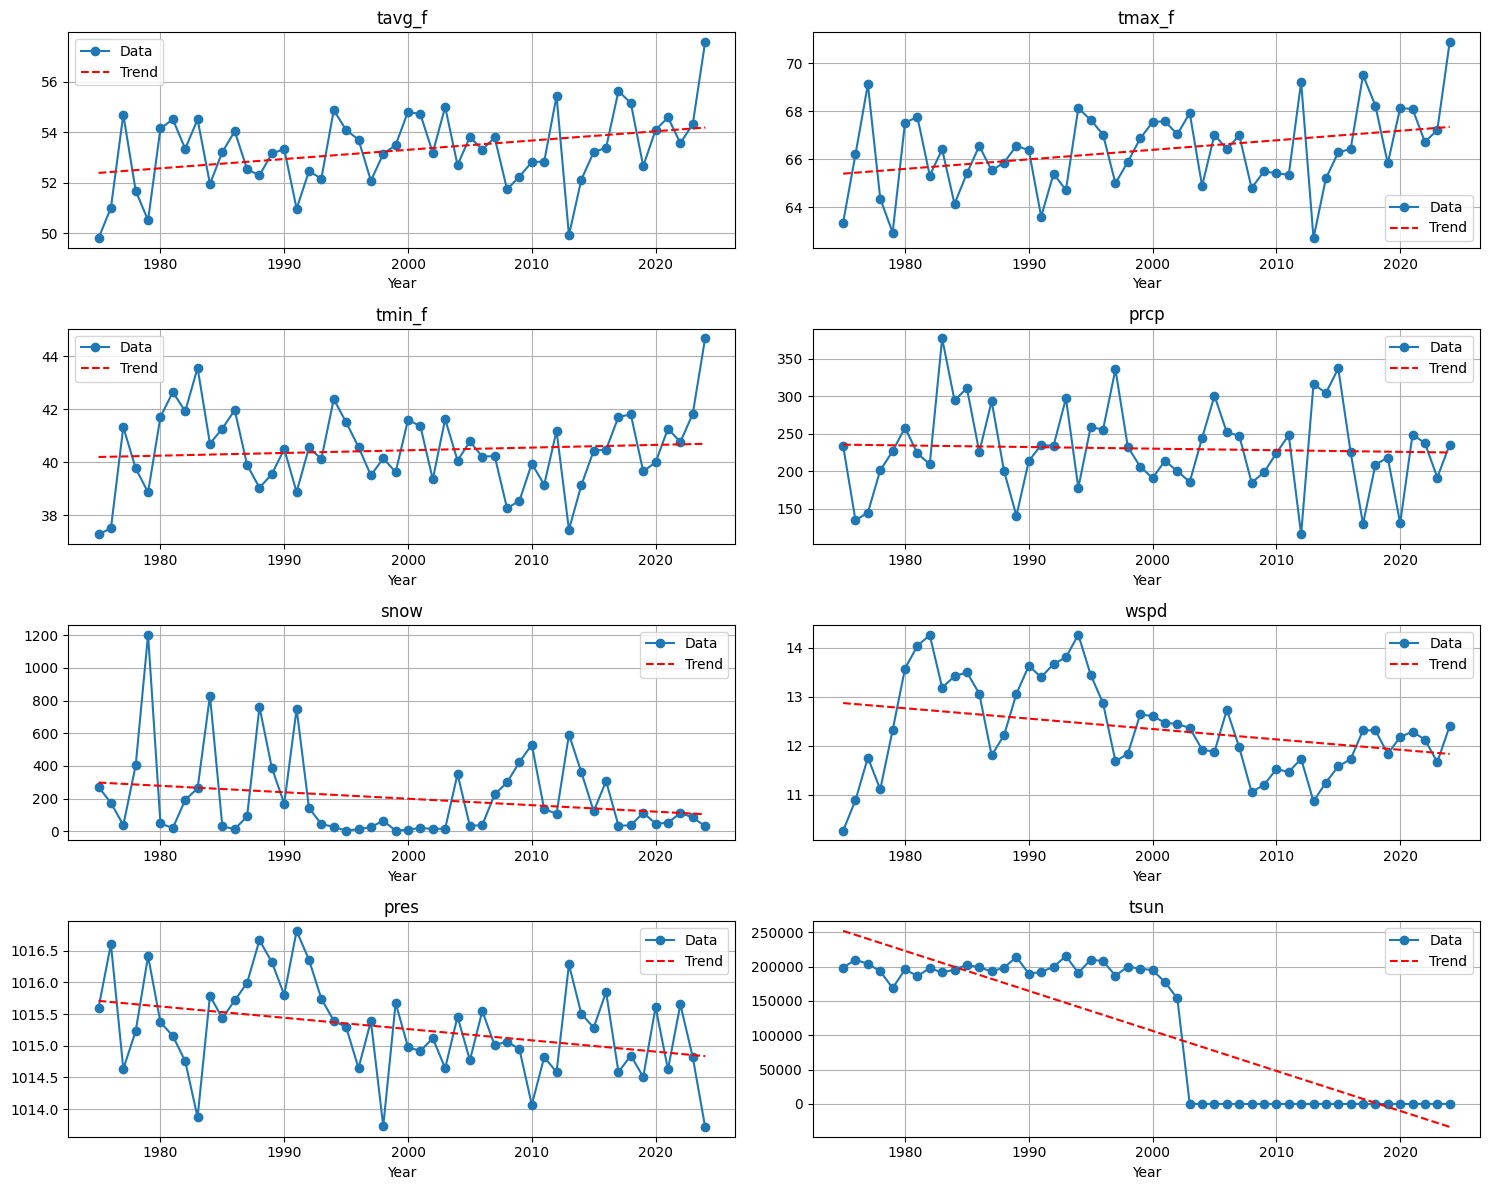

In [97]:
import numpy as np

# Resample to yearly averages/sums
annual = pd.DataFrame({
    "tavg_f": (data['tavg'].resample('YE').mean() * 9/5 + 32),
    "tmax_f": (data['tmax'].resample('YE').mean() * 9/5 + 32),
    "tmin_f": (data['tmin'].resample('YE').mean() * 9/5 + 32),
    "prcp": data['prcp'].resample('YE').sum(),   # total annual precip
    "snow": data['snow'].resample('YE').sum(),   # total annual snow
    "wspd": data['wspd'].resample('YE').mean(),  # avg annual wind speed
    "pres": data['pres'].resample('YE').mean(),  # avg annual pressure
    "tsun": data['tsun'].resample('YE').sum()    # total annual sunshine
})

# Drop all-NaN cols if station doesn’t report them
annual = annual.dropna(axis=1, how='all')

# Remove 2025 row
annual = annual.loc[annual.index.year < 2025]

# Make subplots (grid of plots)
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15,12))
axes = axes.flatten()

years = annual.index.year

for i, col in enumerate(annual.columns):
    y = annual[col].values
    
    # Original time series
    axes[i].plot(years, y, marker='o', label="Data")
    
    # Best fit line
    m, b = np.polyfit(years, y, 1)          # slope & intercept
    axes[i].plot(years, m*years + b, color="red", linestyle="--", label="Trend")
    
    axes[i].set_title(col)
    axes[i].set_xlabel("Year")
    axes[i].grid(True)
    axes[i].legend()

plt.tight_layout()
plt.show()


### Observations: 
There are many observations we can make from these graphs when it comes to both how the data was collected and the data itself. A big thing we can see is that "tsun" which represents daily sunshine duration stops being recorded a little around 2002. Another suspicious category is snowfall. While snow seems to be being measured, there are values near 0 from 1993 to 2003 which doesnt make much sense. There also seems to be suspicious variance from year to year. A lot of this data is probably still good but I am going to drop the two variables anyway. 

When it comes to the data itself, temperature was a big thing I wanted to look at due to claims of climate change/global warming driving average temperatures up. The temperature data for Grand Junction does appear to have a very slight upward trend with 2024 also being the hottest year on average out of our data. The question of whether that is due to climate change, chance, or some other reason cannot be answered with our data alone. Windspeed on the other hand seems to have a minimal decline over the years. Pressure may seem to be going down but if you look at the y-scale the difference is minimal. 

## Clean The Data
Since snow, and tsun is being collected suspiciously, lets drop both of those categories. Lets also drop wind direction since that is not necessarily numerical. 

In [98]:
# Drop columns directly from the original DataFrame
data.drop(columns=['snow', 'tsun', 'wdir'], inplace=True)

print(data.head())
print(data.columns)


            tavg  tmin  tmax  prcp  wspd  wpgt    pres
time                                                  
1975-01-01  -9.0 -13.9  -2.8   0.0   9.4  25.9  1031.4
1975-01-02  -7.6 -12.8  -2.2   0.8   5.6  24.1  1026.3
1975-01-03 -10.1 -17.2  -2.8   0.0   8.1  25.9  1036.2
1975-01-04 -10.2 -17.8  -5.6   0.0   6.3  24.1  1029.8
1975-01-05  -8.1 -15.6  -2.2   0.0   5.3  16.6  1029.1
Index(['tavg', 'tmin', 'tmax', 'prcp', 'wspd', 'wpgt', 'pres'], dtype='object')


## Look For Correlation
Using seaborn and matplotlib, lets create a heatmap to see which variables are correlated with each other. 

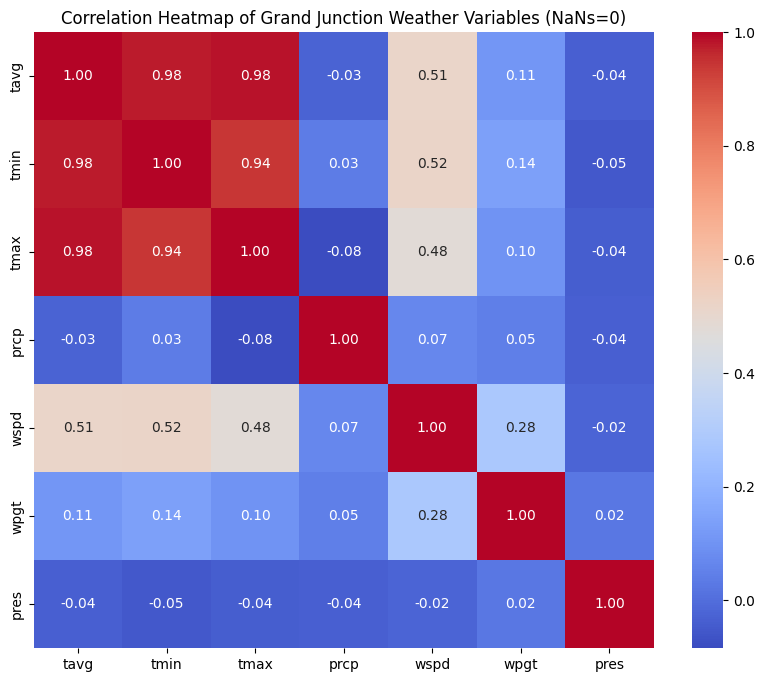

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt

# Replace NaNs with 0
data_zero = data.fillna(0)

# Compute correlation matrix
corr = data_zero.corr()

# Plot heatmap
plt.figure(figsize=(10,8))
sns.heatmap(
    corr,
    annot=True, 
    fmt=".2f",
    cmap="coolwarm",
    cbar=True
)

plt.title("Correlation Heatmap of Grand Junction Weather Variables (NaNs=0)")
plt.show()


### Observations: 
While our findings here are not too suprising, we do see a super strong correlation between average, high and low temperature, which makes sense. We can also see a not as strong correlation between wind speed and temperature. The rest of the variables have close to no correlation at all. 

## Principal Component Analysis

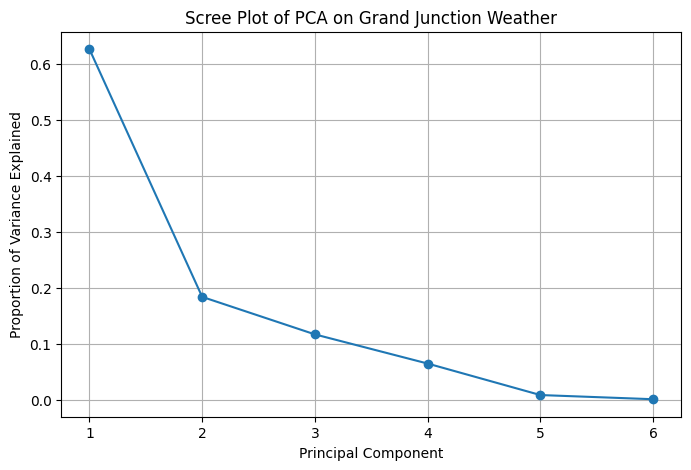

Explained variance ratio:
[0.626 0.184 0.117 0.065 0.008 0.001]

PCA Loadings:
        PC1    PC2    PC3    PC4    PC5    PC6
tavg  0.497 -0.148 -0.246  0.064 -0.067  0.814
tmin  0.494 -0.081 -0.253  0.057  0.754 -0.336
tmax  0.483 -0.214 -0.262  0.100 -0.646 -0.474
prcp  0.020  0.882 -0.428  0.181 -0.075 -0.001
wspd  0.352  0.223  0.715  0.562 -0.011 -0.004
pres -0.389 -0.313 -0.336  0.797  0.057  0.022


In [100]:
# Select variables of interest (drop rows with NaNs)
features = ['tavg', 'tmin', 'tmax', 'prcp', 'wspd', 'pres']
df = data[features].dropna()

# Standardize the data (important for PCA)
X = StandardScaler().fit_transform(df)

# Run PCA
pca = PCA()
principal_components = pca.fit_transform(X)

# Put into DataFrame
pc_df = pd.DataFrame(
    data=principal_components,
    index=df.index,
    columns=[f'PC{i+1}' for i in range(len(features))]
)


# Scree plot
plt.figure(figsize=(8,5))
plt.plot(range(1, len(features)+1), pca.explained_variance_ratio_, marker='o')
plt.title("Scree Plot of PCA on Grand Junction Weather")
plt.xlabel("Principal Component")
plt.ylabel("Proportion of Variance Explained")
plt.grid(True)
plt.show()

loadings = pd.DataFrame(
    pca.components_.T,                 # transpose: rows = features
    index=features,
    columns=[f'PC{i+1}' for i in range(len(features))]
)

print("Explained variance ratio:")
print(pca.explained_variance_ratio_.round(3))

print("\nPCA Loadings:")
print(loadings.round(3))

### Observations: 
The Explained Variation ratio and the skree graph tells us how much of the total variability each principal component is worth. The first principal component captures a little over 60% of it, while the first four capture around 99% of it. 

# Correlation among only Days in July and January
Days from only one month will be similar temperature wise. Because of this, we may see better correlation among each of the variables. 

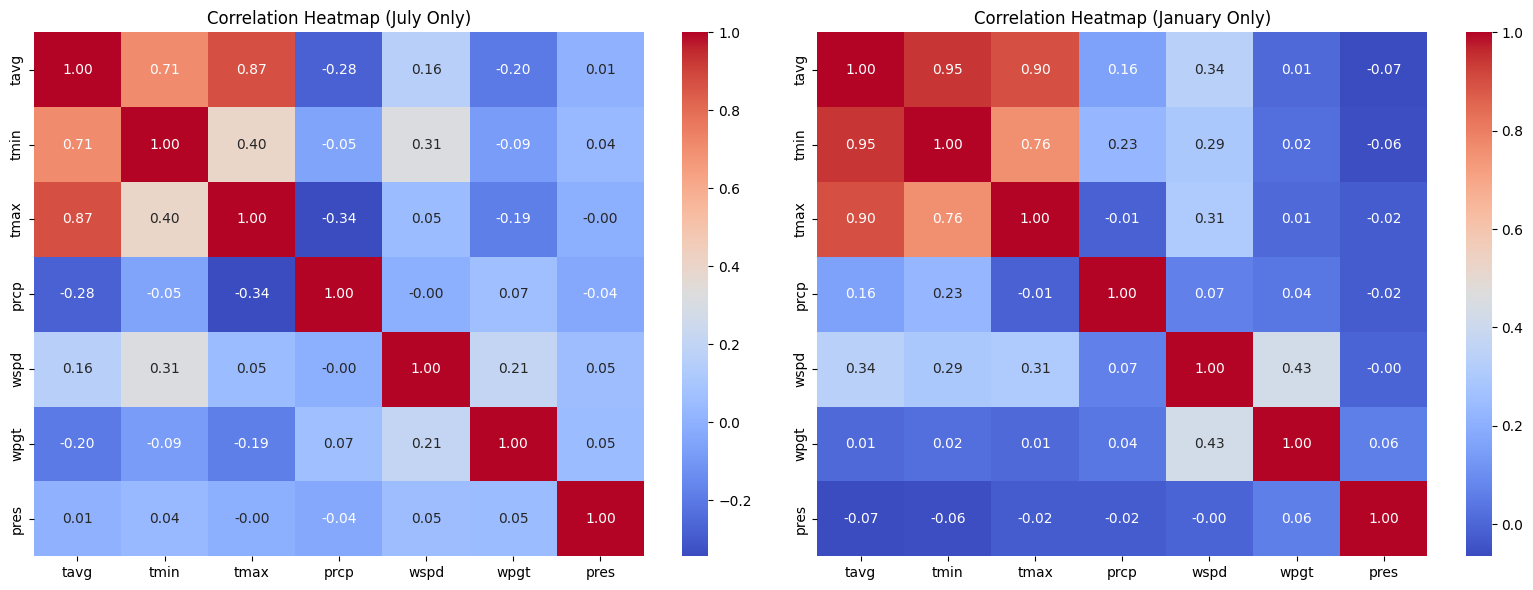

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt

# --- Filter July days ---
july_data = data_clean[data_clean.index.month == 7].fillna(0)
corr_july = july_data.corr()

# --- Filter January days ---
jan_data = data_clean[data_clean.index.month == 1].fillna(0)
corr_jan = jan_data.corr()

# --- Create subplots (2 side-by-side heatmaps) ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# July heatmap
sns.heatmap(
    corr_july, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, ax=axes[0]
)
axes[0].set_title("Correlation Heatmap (July Only)")

# January heatmap
sns.heatmap(
    corr_jan, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, ax=axes[1]
)
axes[1].set_title("Correlation Heatmap (January Only)")

plt.tight_layout()
plt.show()


### Observations: 
Its not a crazy difference but we do have some interesting things to point out. The correlation between average high and average low is not nearly as strong (for both months) compared to the overall data. We also see a better (still not great) correlation between precipitation and temperature in July. 

## More Experiments!

### Plotting Seasonal Temp Over The Yars

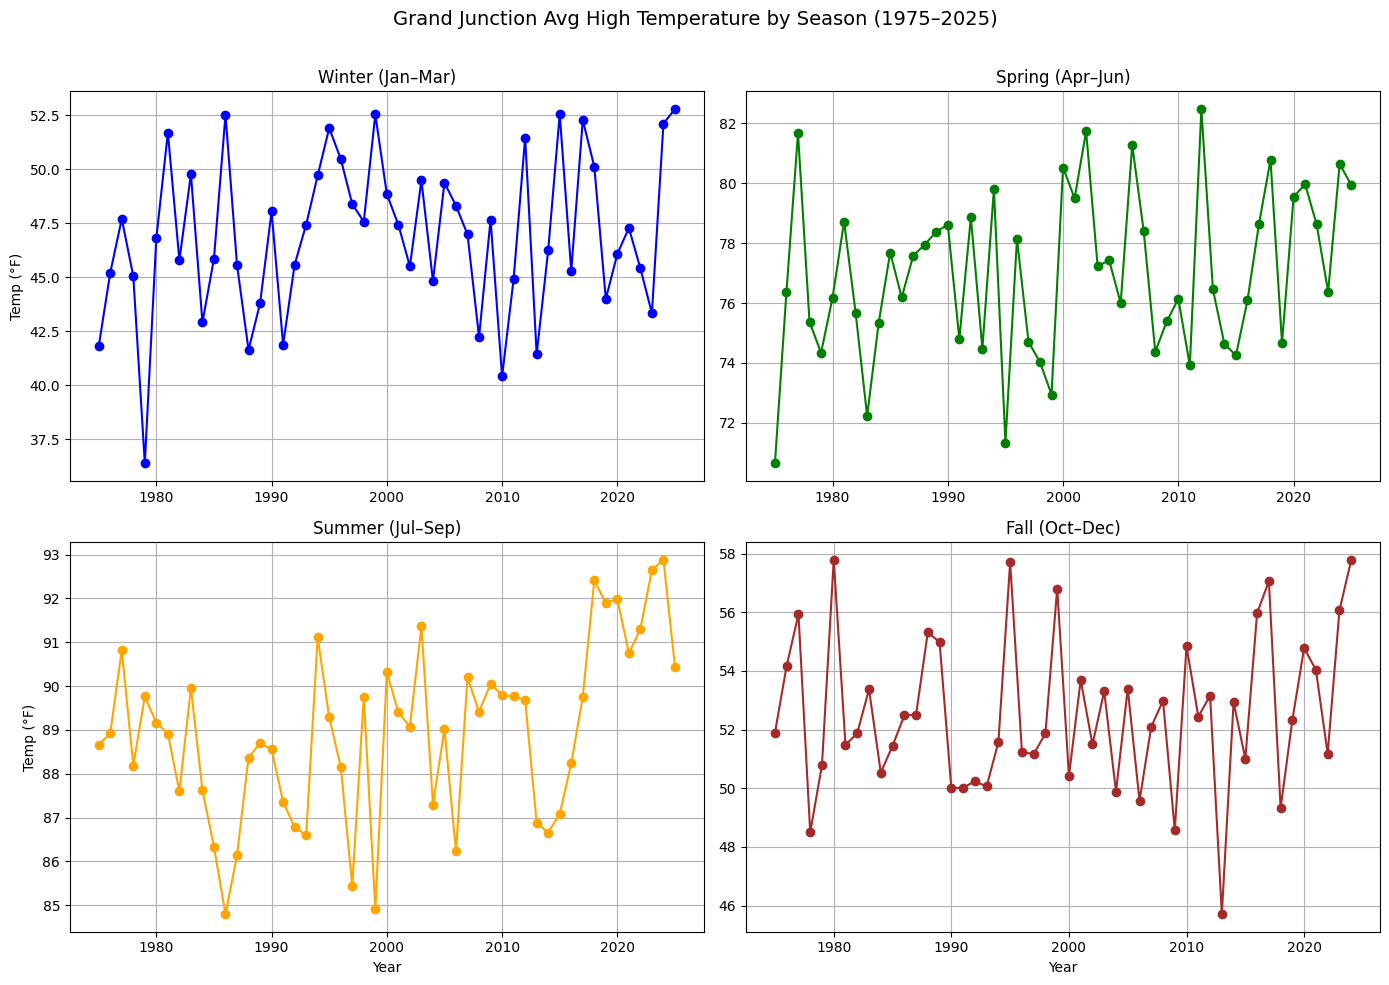

In [84]:
import matplotlib.pyplot as plt

# --- Define seasonal filters ---
winter = data[data.index.month.isin([1, 2, 3])]
spring = data[data.index.month.isin([4, 5, 6])]
summer = data[data.index.month.isin([7, 8, 9])]
fall   = data[data.index.month.isin([10, 11, 12])]

# --- Resample each season to yearly averages (tmax in °F) ---
annual_winter = winter['tmax'].resample('YE').mean() * 9/5 + 32
annual_spring = spring['tmax'].resample('YE').mean() * 9/5 + 32
annual_summer = summer['tmax'].resample('YE').mean() * 9/5 + 32
annual_fall   = fall['tmax'].resample('YE').mean() * 9/5 + 32

# --- Create subplot grid (2 rows × 2 columns) ---
fig, axes = plt.subplots(2, 2, figsize=(14,10))

# Winter
axes[0,0].plot(annual_winter.index.year, annual_winter.values, marker='o', color='blue')
axes[0,0].set_title("Winter (Jan–Mar)")
axes[0,0].set_ylabel("Temp (°F)")
axes[0,0].grid(True)

# Spring
axes[0,1].plot(annual_spring.index.year, annual_spring.values, marker='o', color='green')
axes[0,1].set_title("Spring (Apr–Jun)")
axes[0,1].grid(True)

# Summer
axes[1,0].plot(annual_summer.index.year, annual_summer.values, marker='o', color='orange')
axes[1,0].set_title("Summer (Jul–Sep)")
axes[1,0].set_ylabel("Temp (°F)")
axes[1,0].set_xlabel("Year")
axes[1,0].grid(True)

# Fall
axes[1,1].plot(annual_fall.index.year, annual_fall.values, marker='o', color='brown')
axes[1,1].set_title("Fall (Oct–Dec)")
axes[1,1].set_xlabel("Year")
axes[1,1].grid(True)

plt.suptitle("Grand Junction Avg High Temperature by Season (1975–2025)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


##### Lets see if their is correlation between the seasons!

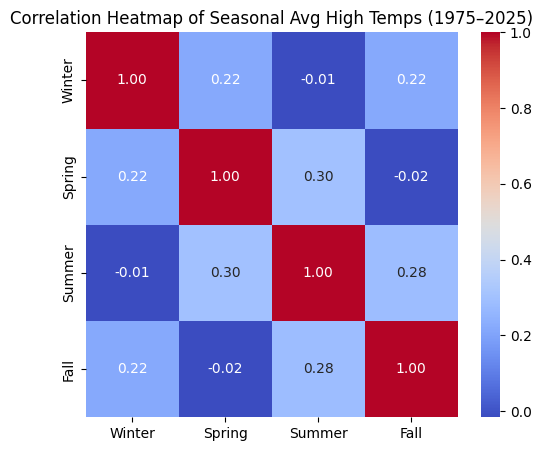

In [85]:
seasonal_df = pd.DataFrame({
    "Winter": annual_winter,
    "Spring": annual_spring,
    "Summer": annual_summer,
    "Fall": annual_fall
})

# Drop any NaNs (early or late years might be partial)
seasonal_df = seasonal_df.dropna()

# --- Correlation matrix ---
corr = seasonal_df.corr()

# --- Plot heatmap ---
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Seasonal Avg High Temps (1975–2025)")
plt.show()

### Observations: 
Our findings are somewhat suprising, especially when it comes to the correlation. The plots show that there might be slightly more variability between each season. 

## Largest day of precipitation each year
Lets get the day with the largest precipiation each year and see if we see anything interesting

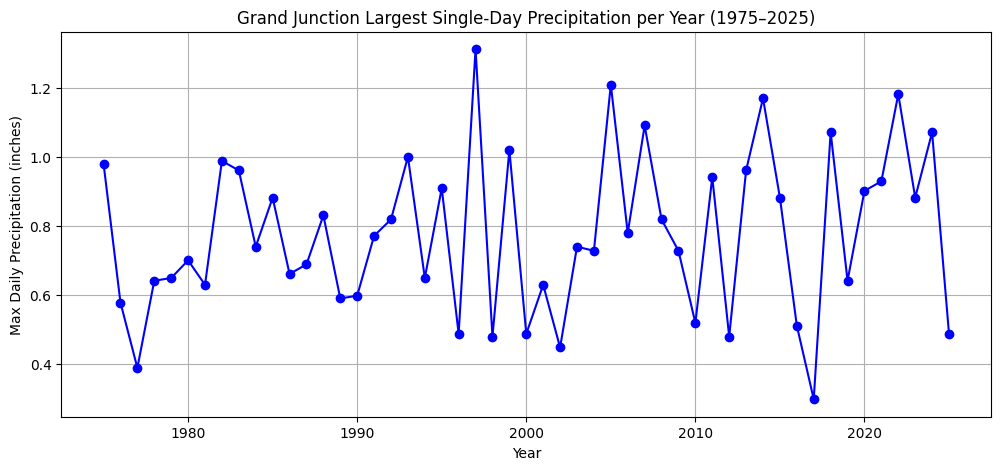

In [86]:
# Make sure precipitation is in the dataset
if 'prcp' in data.columns:
    # Resample: get max daily precipitation per year
    annual_max_prcp = data['prcp'].resample('YE').max()

    # Convert from mm to inches if you prefer U.S. units
    annual_max_prcp_in = annual_max_prcp / 25.4

    # Plot
    plt.figure(figsize=(12,5))
    plt.plot(annual_max_prcp_in.index.year, annual_max_prcp_in.values, marker='o', color='blue')
    plt.title("Grand Junction Largest Single-Day Precipitation per Year (1975–2025)")
    plt.xlabel("Year")
    plt.ylabel("Max Daily Precipitation (inches)")
    plt.grid(True)
    plt.show()
else:
    print("No precipitation column found in dataset.")
